In [301]:
from abc import ABC
import glob
import itertools
import os

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sb
from tqdm import tqdm

pd.set_option("display.max_colwidth", None)

ROOT_DIR = 'D:/data/bms-molecular-translation/'
TRAIN_DIR = os.path.join(ROOT_DIR, "train")

In [302]:
# Abstract class for model

class BMSModel(ABC):
    def read_data():
        pass
    
    def preprocess_images():
        pass
    
    def train():
        pass
    
    def predict():
        pass
    
    def evaluate():
        pass
    
    def submit():
        pass

In [119]:
labels = pd.read_csv(os.path.join('D:/data/bms-molecular-translation/train_labels.csv'))
labels.set_index('image_id', inplace=True)
labels.head()

,InChI
image_id,
000011a64c74,"InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3"
000019cc0cd2,"InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1"
0000252b6d2b,"InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-12-10-20(28)30)27-11-9-16-21(23(25)31)26-29(22(16)24(27)32)18-5-3-4-6-19(18)33-2/h3-8,13H,9-12H2,1-2H3,(H2,25,31)"
000026b49b7e,"InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-24-14)11-15(21)19-17(16(22)23)8-4-2-3-5-9-17/h6-7,10,13H,2-5,8-9,11H2,1H3,(H,18,20)(H,19,21)(H,22,23)"
000026fc6c36,"InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7-8)5-2-3-9(11)16/h8H,2-7H2,1H3,(H2,11,16)(H,12,14)"


In [59]:
folders = '0123456789abcdef'
for _tuple in list(itertools.product(folders, repeat=3)):
    assert os.path.exists(os.path.join(TRAIN_DIR, '/'.join(_tuple))) == True

In [75]:
EXAMPLES = []
for _ in [i for i in folders]:
    EXAMPLES.append(glob.glob(f'{TRAIN_DIR}/0/0/{_}/*'))
EXAMPLES = list(itertools.chain.from_iterable(EXAMPLES))
print(f'Examples found: {len(EXAMPLES)}')

Examples found: 9550


In [186]:
def show_images(images, n_cols=1, n_rows=5):
    if n_cols >= 2:
        fig, ax = plt.subplots(n_rows, n_cols, figsize=(17, 15))
        for _ in range(n_rows*n_cols):
            ix, iy = _//n_cols, _%n_cols
            image = cv2.imread(images[_])
            ax[ix, iy].imshow(image)
            ax[ix, iy].xaxis.set_visible(False)
            ax[ix, iy].yaxis.set_visible(False)
            filename = os.path.basename(images[_]).split('.')[0]
            ax[ix, iy].set_title(labels['InChI'].iloc[_])
    else:
        for _ in range(n_rows*n_cols):
            image = cv2.imread(images[_])
            plt.imshow(image)
            plt.gca().xaxis.set_visible(False)
            plt.gca().yaxis.set_visible(False)
            filename = os.path.basename(images[_]).split('.')[0]
            plt.title(labels['InChI'].iloc[_])
            plt.show()

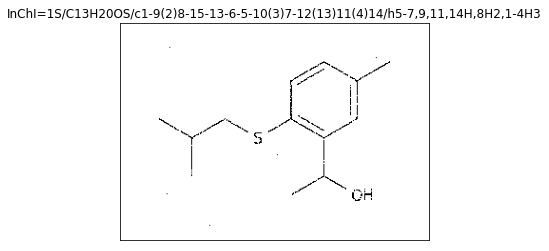

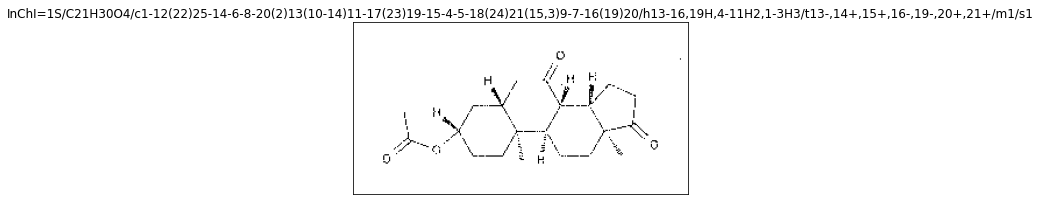

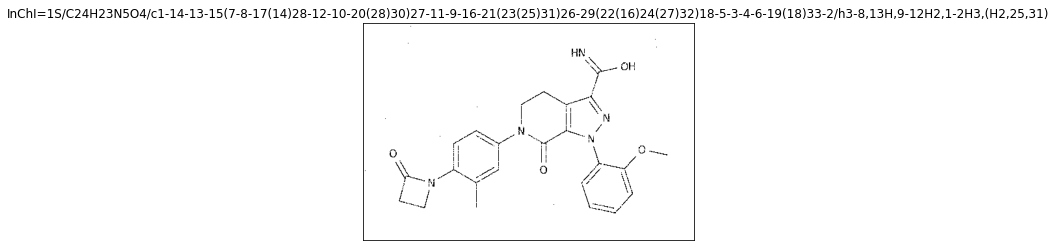

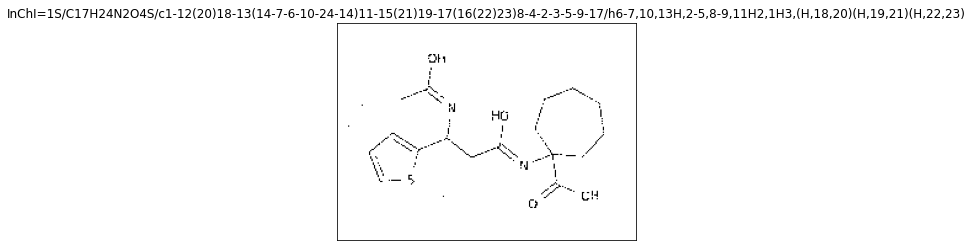

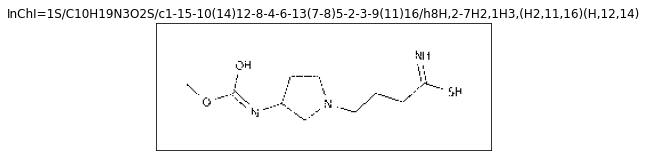

In [187]:
show_images(EXAMPLES)

In [108]:
# Levenshtein distance from
# https://blog.paperspace.com/implementing-levenshtein-distance-word-autocomplete-autocorrect/

def levenshtein_distance(token1, token2):
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(token1)][len(token2)]

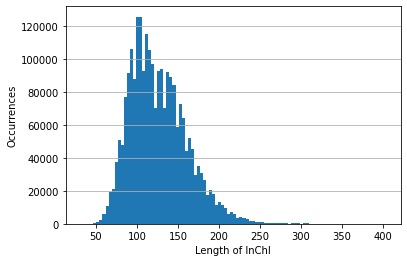

In [205]:
plt.hist(labels.apply(lambda x: len(x["InChI"]), axis=1).values, bins=100);
plt.xlabel("Length of InChI")
plt.ylabel("Occurrences")
plt.grid(axis="y")

In [223]:
sizes = []
for image in tqdm(EXAMPLES):
    cur_image = cv2.imread(image)
    filename = os.path.basename(image).split('.')[0]
    sizes.append((filename, *cur_image.shape))

100%|████████████████████████████████████████████████████████████████████████████| 9550/9550 [00:03<00:00, 2470.79it/s]


In [224]:
image_sizes = pd.DataFrame(sizes, columns=["image_id", 'height', 'width', 'channels'])
image_sizes.head()

,image_id,height,width,channels
0,000011a64c74,229,325,3
1,000019cc0cd2,148,288,3
2,0000252b6d2b,335,509,3
3,000026b49b7e,177,243,3
4,000026fc6c36,112,294,3


Mean height: 220.94115183246075 +- 75.83811011140864
Mean width: 382.2350785340314 +- 139.3999336155134
Mean channel: 3.0 +- 0.0


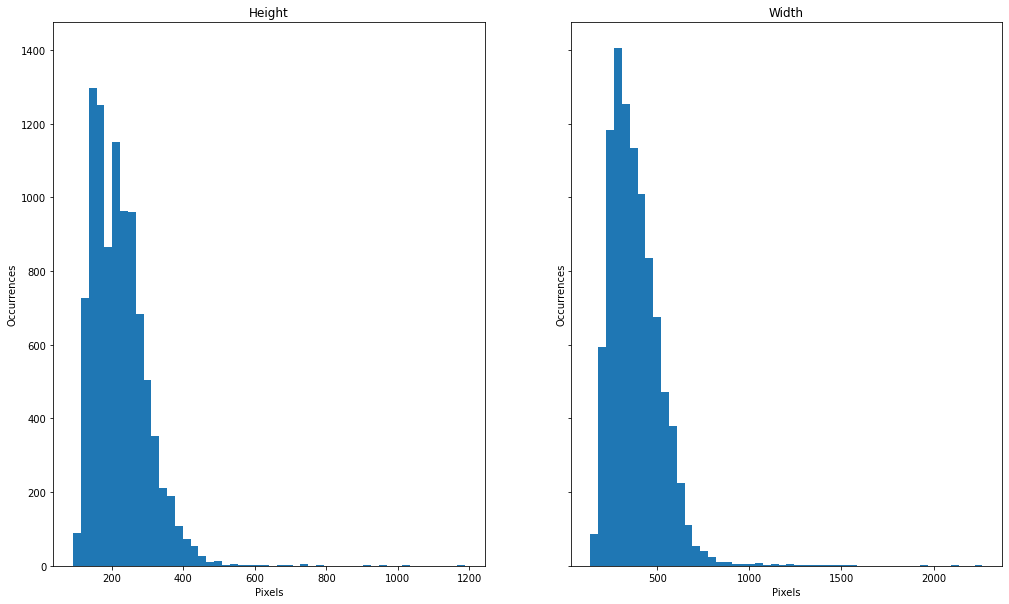

In [241]:
fig, ax = plt.subplots(1, 2, figsize=(17, 10), sharey=True)
heights = image_sizes['height'].values
widths = image_sizes['width'].values
channels = image_sizes['channels'].values
ax[0].hist(heights, bins=50);
ax[0].set_xlabel("Pixels")
ax[0].set_ylabel("Occurrences")
ax[0].set_title("Height")
ax[1].hist(widths, bins=50);
ax[1].set_xlabel("Pixels")
ax[1].set_ylabel("Occurrences")
ax[1].set_title("Width")

print(f"Mean height: {np.mean(heights)} +- {np.std(heights)}")
print(f"Mean width: {np.mean(widths)} +- {np.std(widths)}")
print(f"Mean channel: {np.mean(channels)} +- {np.std(channels)}")

In [354]:
def preprocess_images():
    images = []
    height, width = 220, 384
    
    def crop_image(image):
        blur = cv2.GaussianBlur(image, (15, 15), -1)
        _ , thresh = cv2.threshold(~blur, 0, 255, 128)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        # Find largest rectangular contour and crop it
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        ry, rx = image.shape
        image = image[max(y, 0): min(y+h, ry), max(x, 0): min(x+w, rx)]
        #plt.imshow(example, cmap="inferno")
        return image
    
    for image in EXAMPLES[:2]:
        cur_image = cv2.imread(image)
        convert = cv2.cvtColor(cur_image, cv2.COLOR_BGR2GRAY)
        crop = crop_image(convert)
        #resize = cv2.resize(convert, (height, width), cv2.INTER_AREA)
        images.append(convert)
    return images

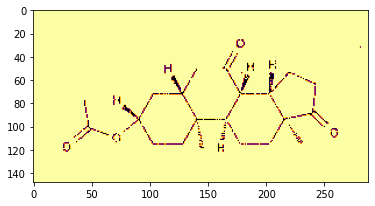

In [355]:
plt.imshow(preprocess_images()[1], cmap="inferno")

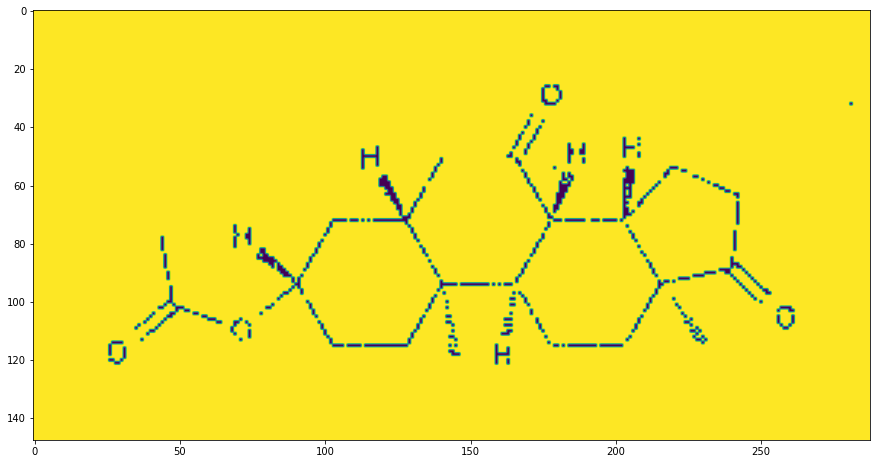

In [362]:
example = preprocess_images()[1]
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2), (-1, -1))
blurred = cv2.GaussianBlur(example, (7, 7), -1)
plt.figure(figsize=(15, 10))
plt.imshow(example)

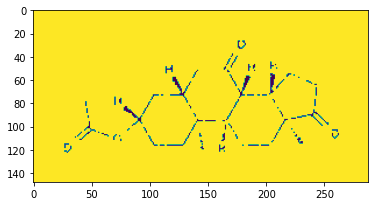

In [363]:
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2), (-1, -1))
opening = cv2.morphologyEx(example, cv2.MORPH_OPEN, element)
plt.imshow(opening)

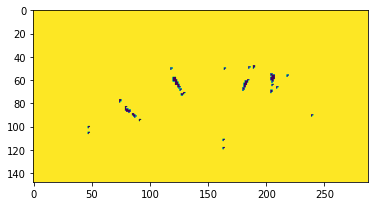

In [364]:
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2), (-1, -1))
closing = cv2.morphologyEx(example, cv2.MORPH_CLOSE, element)
plt.imshow(closing)

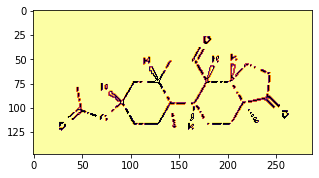

In [369]:
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2), (-1, -1))
morph = cv2.morphologyEx(opening, cv2.MORPH_GRADIENT, element)
plt.figure(figsize=(5, 5))
plt.imshow(~morph, cmap="inferno")

In [206]:
import tensorflow.keras as tk

In [208]:
model = tk.models.Sequential()
model